In [101]:
!pip install --upgrade albumentations
!pip install --upgrade torch_lr_finderxw

ERROR: Could not find a version that satisfies the requirement torch_lr_finderxw (from versions: none)
ERROR: No matching distribution found for torch_lr_finderxw


In [102]:
import torch
import torchvision
import cv2
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
import time
from copy import deepcopy

%matplotlib inline

conv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [103]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

# torch.backends.cudnn.benchmark = True

In [104]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [105]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [106]:
type(train_set.data), type(train_set.targets)

(numpy.ndarray, list)

In [107]:
# calculate mean and standard deviation

mean = np.mean(train_set.data, axis=(0,1,2))


sdev = np.std(train_set.data, axis=(0, 1, 2))


In [108]:
mean.shape

(3,)

In [109]:
mean = mean/255
sdev = sdev/255

In [110]:
SEED = 101
BATCH = 512

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [111]:
# # dataset= dsets.CIFAR10(root='./cifar10/data/', transform=transform, train= True, download=True)
# # test_set= dsets.CIFAR10(root="./cifar10/data/", transform=transform, train= False)

# def ZCA_whitening(X):
#     X= X.reshape((-1, np.product(X.shape[1:])))
#     X_centered= X - np.mean(X, axis= 0)
#     Sigma= np.dot(X_centered.T, X_centered) / X_centered.shape[0]
#     U, Lambda, _= np.linalg.svd(Sigma)
#     W= np.dot(U, np.dot(np.diag(1.0/np.sqrt(Lambda + 1e-5)), U.T))
    
#     X_ZCA= np.dot(X_centered, W.T)
#     X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
#     return X_ZCA_rescaled

# # dataset_zca= ZCA_whitening(dataset.train_data)
# # test_set_zca= ZCA_whitening(test_set.test_data)

# # dataset_zca= torch.tensor(dataset_zca.reshape(-1,32,32,3))
# # test_set_zca= torch.tensor(test_set_zca.reshape(-1,32,32,3))

# # torch.Tensor(dataset.train_data)
# # torch.Tensor(test_set.test_data)

In [112]:
# class GaussNoise():
#     def __init__(self, mean , sdev):
#         self.mean = mean
#         self.sdev = sdev
    
#     def __call__(self, tensor=None, size=None):
#         if tensor:
#             val= torch.rand(tensor.size(), dtype=tensor.dtype) * self.sdev + self.mean

#             return val
#         else:
#             return np.random.rand(size) * self.sdev + self.mean

In [113]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [114]:
# noise = GaussNoise(mean=mean, sdev=sdev)
# noise_to_add = noise(size=mean.shape[0])
lr_epochs = []
# noise(size=1)[0], noise_to_add

In [115]:
def apply_ricap(*, batch, beta=0.3):

    input, target = batch

    I_x, I_y = input.size()[2:]

    w = int(np.round(I_x * np.random.beta(beta, beta)))
    h = int(np.round(I_y * np.random.beta(beta, beta)))
    w_ = [w, I_x - w, w, I_x - w]
    h_ = [h, h, I_y - h, I_y - h]

    cropped_images = {}
    c_ = {}
    W_ = {}

    for k in range(4):
        idx = torch.randperm(input.size(0))
        x_k = np.random.randint(0, I_x - w_[k] + 1)
        y_k = np.random.randint(0, I_y - h_[k] + 1)
        cropped_images[k] = input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
        c_[k] = target[idx].cuda()
        W_[k] = w_[k] * h_[k] / (I_x * I_y)

    patched_images = torch.cat(
        (torch.cat((cropped_images[0], cropped_images[1]), 2),
         torch.cat((cropped_images[2], cropped_images[3]), 2)),
        3)

    patched_images = patched_images.cuda()
    
    return patched_images

In [116]:
def train(model, device, train_loader, optimizer, scheduler, criterion, train_acc, train_loss):   
    model.train()
    pbar = tqdm(train_loader)
    scaler = torch.cuda.amp.GradScaler()  # create grad scaler
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)
        loss.backward()

        optimizer.step()
        scheduler.step()

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f'Loss={loss.item()} Accuracy={100 * correct / processed:0.2f}')
    train_loss.append(loss.data.cpu().numpy().item())
    train_acc.append(100 * correct / processed)

In [117]:
def test(model, device, test_loader, test_acc, test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.5f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [118]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1,
                     criterion=None,
                     test=False, test_loader=None,
                     scheduler=None,
                     grad_clip=None,
                     grad_clip_start_epoch=None,
                     grad_clip_end_epoch=None,
                     l1=False, lambda_1=0.001,
                     noise_level=0.1,
                     ricap_apply=False,
                     ricap_beta=0.3,
                     ricap_prob=0.1):
    if not model:
        raise NotImplementedError("\nNo model provided")
    if not train_loader:
        raise NotImplementedError("\nTrain Loader not provided")
    if not optimizer:
        raise NotImplementedError("\nOptimizer not provided")
    if not device:
        raise ValueError("\nno device provided, kindly provide CPU or Cuda to use")
    if ricap_apply:
        print(f"\n\nRICAP has been set to True with probability: {ricap_prob} and Beta value: {ricap_beta}")
    
    # if `criterion` is not given use CrossEntropy Loss as default
    if not criterion:
        criterion = nn.CrossEntropyLoss()

    scaler = torch.cuda.amp.GradScaler()  # create grad scaler
    
    # iterate over for `epochs` epochs and keep storing valuable info
    for epoch in range(epochs):
        print(f"\n\n\nepoch num ===================================== {epoch + 1}")
        correct = processed = train_loss = regularization_loss = 0
        model.train()  # set the train mode
        pbar = tqdm(train_loader)
        ricap_count = 0

        if scheduler:
            last_lr = scheduler.get_last_lr()
            lr_epochs.append((epoch + 1, last_lr))
            print(f"LR at epoch {epoch + 1} start: -->", last_lr, end="\n\n")

        if l1:
            for param in model.parameters():
                regularization_loss += torch.sum(abs(param))

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)  # move data to `device`

            optimizer.zero_grad()  # zero out the gradients to avoid accumulating them over loops

            # apply RICAP is flag is True and `ricap_prob` greater than random number
            if ricap_apply and (ricap_prob > np.random.random()):
                # print(f"Applying RICAP")
                ricap_count += 1
                data = apply_ricap(batch=(data, target), beta=ricap_beta)

            # with torch.cuda.amp.autocast():
            output = model(data)  # get model's predictions
              
            loss = criterion(output, target) + lambda_1 * regularization_loss
            #   loss += noise(tensor=loss)

            train_loss += loss.item()

            # scaler.scale(loss).backward()
            loss.backward() # to perform backpropagation and calculate the gradients

            # if gradient clipping is to be used
            if grad_clip and grad_clip_start_epoch <= epoch <= grad_clip_end_epoch:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step() # take 1 step for the optimizer and update the weights

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            correct += pred.eq(target.view_as(
                pred)).sum().item()  # compare and see how many predictions are coorect and then add up the count

            processed += len(data)  # total processed data size

            # scaler.step(optimizer)
            # scaler.update()

            if scheduler:
                scheduler.step()

        acc = 100 * correct / processed

        train_losses.append(train_loss)

        train_accuracy.append(acc)

        pbar.set_description(desc=f'loss={loss.item()} batch_id={batch_idx}')

        total_batch_iters = len(train_loader)
        ricap_perc = ricap_count/total_batch_iters
        print(f"\n\nRicap applied: {ricap_perc * 100:.2f} percent of total batch iterations")

        train_loss /= len(train_loader.dataset)
        print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct, len(train_loader.dataset),
                                                                        correct * 100 / len(train_loader.dataset)))

        if test:  # moving to evaluation
            model.eval()  # set the correct mode
            correct = test_loss = 0

            with torch.no_grad():  # to disable gradient calculation with no_grad context
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)

                    output = model(data)

                    test_loss += criterion(output, target).sum().item()  # sum up batch loss

                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

                    correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            test_accuracy.append(100. * correct / len(test_loader.dataset))

            print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))


In [145]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [146]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [227]:
# transforms
# cutout p: 0.5 -> 0.4 -> 0.2 -> 
# scshrt: 0.2-> 
train_transforms = A.Compose([     
                    A.Sequential([
                    A.CropAndPad(px=4, keep_size=False),
                    A.RandomCrop(32,32)]),
                    A.HorizontalFlip(p=0.5),
                    A.ShiftScaleRotate(rotate_limit=30, p=0.1),
                    A.ColorJitter(p=0.2),
                    # A.FancyPCA(p=0.15),
                    A.CoarseDropout(p=0.3, max_holes = 1, min_holes=1, max_height=8, max_width=8,
                                    fill_value=(0.4914, 0.4822, 0.4465)),
                    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                    ToTensorV2(),
                    ])

test_transforms = A.Compose([
                  A.HorizontalFlip(p=0.3),
                #   A.ShiftScaleRotate(rotate_limit=30, p=0.1),
                  A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                  ToTensorV2()
                ])

In [228]:

# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

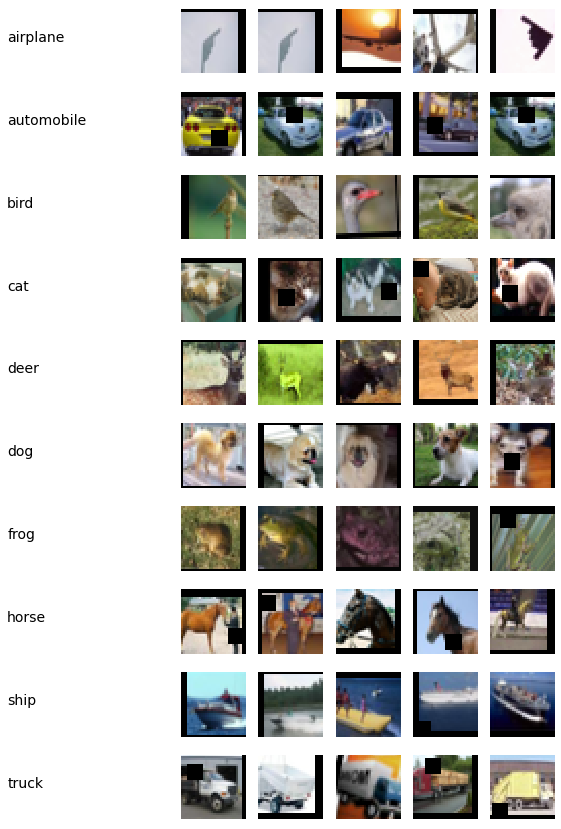

In [229]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [151]:
# class GBN(torch.nn.Module):
#     """
#     Ghost Batch Normalization
#     """

#     def __init__(self, input_dim, virtual_batch_size=128, momentum=0.01):
#         super(GBN, self).__init__()

#         self.input_dim = input_dim
#         self.virtual_batch_size = virtual_batch_size
#         self.bn = nn.BatchNorm2d(self.input_dim, momentum=momentum)

#     def forward(self, x):
#         chunks = x.chunk(int(np.ceil(x.shape[0] / self.virtual_batch_size)), 0)
#         res = [self.bn(x_) for x_ in chunks]

#         return torch.cat(res, dim=0)

In [152]:
# def get_conv_block(in_channels=3, out_channels=64, max_pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)]
    
#     if max_pool:
#         layers.append(nn.MaxPool2d(2))

#     layers.extend([nn.BatchNorm2d(out_channels, momentum=0.8),
#                    nn.ReLU(inplace=True)])

#     return nn.Sequential(*layers)

# """Pre-activated approach, try with this now
#    Only notable difference is pre-act block is 1 second quicker on each epoch
# """

# # def get_conv_block(in_channels=3, out_channels=64, max_pool=False, groups=1):
# #     layers = [nn.BatchNorm2d(in_channels, momentum=0.7),
# #                    nn.ReLU(inplace=True)]
    
# #     if max_pool:
# #         layers.append(nn.MaxPool2d(2))

# #     layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, groups=groups, bias=False))

# #     return nn.Sequential(*layers)

# class CustomResNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.in_planes = 3
#         self.num_classes = num_classes
        
#         # use this if pre-act block is used
#         # self.conv1 = nn.Sequential(
#         #     nn.Conv2d(in_planes, 64, 3, padding=1, bias=False),
#         #     nn.BatchNorm2d(64, momentum=0.7),
#         #     nn.ReLU(inplace=True)
#         # )

#         self.conv1 = get_conv_block(3, 64)

#         self.conv2 = get_conv_block(in_channels = 64, out_channels = 128, max_pool=True)

#         self.res1 = nn.Sequential(get_conv_block(in_channels=128, out_channels=128), get_conv_block(in_channels=128, out_channels=128))
        
#         self.conv3 = get_conv_block(128, 256, max_pool=True)

#         self.conv4 = get_conv_block(256, 512, max_pool=True)
        
#         self.res2 = nn.Sequential(get_conv_block(512, 512), get_conv_block(512, 512))
#         self.last_mx = out = nn.MaxPool2d(4)
#         self.classifier = nn.Linear(512, num_classes, bias=False)
#         # self.extra_1 = nn.Sequential(
#         #     nn.Conv2d(64, 128, 1, stride=2),
#         #     nn.BatchNorm2d(128),
#         #     nn.ReLU(),
#         #     nn.Conv2d(128, 256, 3, stride=1, padding=1),
#         #     nn.BatchNorm2d(256),
#         #     nn.ReLU(),
#         #     nn.MaxPool2d(2)
#         # )
        
#     def forward(self, x):
#         x1 = out = self.conv1(x)
#         out = self.conv2(out)
#         out = out + self.res1(out)
#         out = self.conv3(out) #+ self.extra_1(x1)
#         out = self.conv4(out)
#         out = out + self.res2(out)
#         out = self.last_mx(out)
#         out = out.view(out.size(0), -1)
#         out = self.classifier(out)
#         # out = out.view(-1, self.num_classes)
#         out = F.softmax(out, dim=-1)
#         return out

In [232]:
# re-write

conv3x3 = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
bn_momentum = 0.2
class CustomResNet(nn.Module): 
    def __init__(self):
        super().__init__()
        self.prep = nn.Sequential(
            conv3x3(3, 64, 3, padding=1), 
            bn(64,momentum=bn_momentum),
            nn.ReLU())

        self.layer1 = nn.Sequential(
            conv3x3(64, 128, 3, padding=1), 
            nn.MaxPool2d(2, 2),
            bn(128,momentum=bn_momentum),
            nn.ReLU())

        self.res1 = nn.Sequential(
            conv3x3(128, 128, 3, padding=1), 
            bn(128,momentum=bn_momentum),
            nn.ReLU(),
            conv3x3(128, 128, 3, padding=1), 
            bn(128,momentum=bn_momentum),
            nn.ReLU()
        )

        self.layer2 =  nn.Sequential(
            conv3x3(128, 256,3, padding=1), 
            nn.MaxPool2d(2, 2),
            bn(256,momentum=bn_momentum),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            conv3x3(256, 512, 3, padding=1), 
            nn.MaxPool2d(2, 2),
            bn(512,momentum=bn_momentum),
            nn.ReLU()
        )

        self.res3 = nn.Sequential(
            conv3x3(512, 512, 3, padding=1), 
            bn(512,momentum=bn_momentum),
            nn.ReLU(),
            conv3x3(512, 512, 3, padding=1),
            bn(512,momentum=bn_momentum),
            nn.ReLU()
        )

        self.final_max = nn.MaxPool2d(4)
        self.fc = nn.Linear(in_features = 512, out_features = 10, bias=False)

    def forward(self, x):

        prep = self.prep(x)

        layer1 = self.layer1(prep)
        res1 = self.res1(layer1)
        layer1 = layer1 + res1

        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        res3 = self.res3(layer3)
        layer3 = layer3 + res3

        max = self.final_max(layer3)
        out = max.view(max.size(0),-1)

        fc = self.fc(out)
        
        out = F.log_softmax(fc.view(-1,10), dim=-1)
        # out  = fc.view(-1,10)
        return out

In [233]:
model = CustomResNet().to(device)

# criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [192]:
# def custom_lr_finder(*, model=None, max_lr=0.1, min_lr=0.0001, strategy="exp", beta=0.9,
#                      optimizer=None, criterion=None, momentum=0.9, weight_decay=0.00001,
#                      train_loader=None, test_loader=None):
    
#     if not model:
#         raise NotImplementedError("Pass the model at least!")
#     if not (train_loader and test_loader):
#         raise NotImplementedError("This does not work without `train_loader` and `test_loader`, kindly pass these two.")
#     if not criterion:
#         criterion = nn.CrossEntropyLoss()
#     if not optimizer:
#         optimizer = optim.SGD
    
#     import math

#     steps = len(train_loader)
#     print(f"\nTotal steps: {steps} | LR strategy: {strategy}")

#     def get_linear_lrs():
#         return np.linspace(start=min_lr, stop=max_lr, num=steps).tolist()

#     def get_exp_lrs():
#         lr_multiplier = (max_lr / min_lr) ** (1.0 / steps)
#         curr = min_lr
#         lrs = [curr]
#         for i in range(1, steps):
#             curr = curr * lr_multiplier
#             lrs.append(curr)
#         return lrs

#     if "linear" in strategy.lower():
#         all_lrs = get_linear_lrs()
#     elif "exp" in strategy.lower():
#         all_lrs = get_exp_lrs()

#     lr_vs_train_loss = []
#     iteration_vs_lr = []
    
#     running_loss = 0.
#     model.train() # train_mode
#     optim_ = optimizer(model.parameters(), lr=min_lr, momentum=momentum, weight_decay=weight_decay)
#     lr = min_lr
#     for step, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optim_.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         running_loss = beta * running_loss + (1 - beta) * loss.item()
#         smooth_loss = running_loss /(1 - beta ** step)
#         print(f"step: {step} | running_loss: {running_loss:.5f} | smooth_loss: {smooth_loss:.5f}")
#         loss.backward()
#         optim_.step()
        
#         lr_vs_train_loss.append((lr, math.log(lr, 10), smooth_loss))
#         iteration_vs_lr.append(lr)

#         optim_.param_groups[0]['lr'] = lr = all_lrs[step]

#     return {"lrs": iteration_vs_lr,  "lr_vs_train_loss": lr_vs_train_loss}

In [170]:
def find_lr(init_value = 1e-6, final_value=10., beta = 0.98):
    import math
    num = len(train_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        # log_lrs.append(math.log10(lr))
        log_lrs.append(lr)
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

In [177]:
criterion = nn.CrossEntropyLoss()
# criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)

optimizer = optim.SGD(model.parameters(), momentum=0.9, lr = 0.001, nesterov=True, weight_decay=0.00005)
model = CustomResNet().to(device)

# info = custom_lr_finder(model=model, 
#                         max_lr=1, min_lr=1e-4, strategy="exp",
#                         optimizer=optim.SGD, momentum=0.9, beta=0.97,
#                         weight_decay=0.0001, train_loader=train_loader,
#                         test_loader=test_loader)

lrs, losses = find_lr(init_value=0.001, final_value=0.07, beta=0.98)

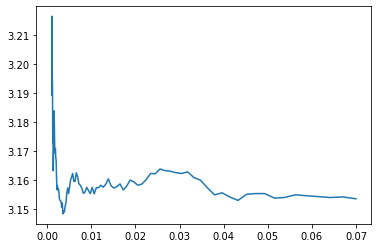

In [178]:
plt.plot(lrs,losses) # without decay with CrossEntropy:    2e-4 with softmax, without softmax bad curve, in order of 10-6
                     # without decay with label smoothing: without softmax: bad in terms of 10-6,  with softmax: steepest in 10-6, another low loss near 1/2e-2



In [234]:
# criterion = nn.CrossEntropyLoss()
# criterion = LabelSmoothingLoss(10, 0.1)
model = CustomResNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.032, total_steps=None,
                                          pct_start=0.18, anneal_strategy='linear',
                                          epochs=24, steps_per_epoch=len(train_loader),
                                          div_factor=10.0,final_div_factor =1, cycle_momentum=False)

LR = []
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(24):
    print(f"\nEpoch num: {epoch+1}  |  LR: {optimizer.param_groups[0]['lr']:.5f}", end="\n")
    LR.append(optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer,scheduler,criterion, train_accuracy, train_losses)
    test(model, device, test_loader,test_accuracy, test_losses)

  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 1  |  LR: 0.00320


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00278, Accuracy: 5428/10000 (54.280%)


Epoch num: 2  |  LR: 0.00988


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00209, Accuracy: 6457/10000 (64.570%)


Epoch num: 3  |  LR: 0.01656


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00270, Accuracy: 6435/10000 (64.350%)


Epoch num: 4  |  LR: 0.02325


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00255, Accuracy: 6618/10000 (66.180%)


Epoch num: 5  |  LR: 0.02993


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00134, Accuracy: 7882/10000 (78.820%)


Epoch num: 6  |  LR: 0.03099


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00147, Accuracy: 7901/10000 (79.010%)


Epoch num: 7  |  LR: 0.02953


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00118, Accuracy: 8270/10000 (82.700%)


Epoch num: 8  |  LR: 0.02806


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00119, Accuracy: 8254/10000 (82.540%)


Epoch num: 9  |  LR: 0.02660


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00113, Accuracy: 8317/10000 (83.170%)


Epoch num: 10  |  LR: 0.02514


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00082, Accuracy: 8662/10000 (86.620%)


Epoch num: 11  |  LR: 0.02367


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00078, Accuracy: 8752/10000 (87.520%)


Epoch num: 12  |  LR: 0.02221


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00083, Accuracy: 8717/10000 (87.170%)


Epoch num: 13  |  LR: 0.02075


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00081, Accuracy: 8748/10000 (87.480%)


Epoch num: 14  |  LR: 0.01928


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00069, Accuracy: 8927/10000 (89.270%)


Epoch num: 15  |  LR: 0.01782


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00073, Accuracy: 8880/10000 (88.800%)


Epoch num: 16  |  LR: 0.01636


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00065, Accuracy: 8997/10000 (89.970%)


Epoch num: 17  |  LR: 0.01489


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00070, Accuracy: 8941/10000 (89.410%)


Epoch num: 18  |  LR: 0.01343


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00067, Accuracy: 9010/10000 (90.100%)


Epoch num: 19  |  LR: 0.01197


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00067, Accuracy: 9028/10000 (90.280%)


Epoch num: 20  |  LR: 0.01050


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00059, Accuracy: 9083/10000 (90.830%)


Epoch num: 21  |  LR: 0.00904


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00063, Accuracy: 9095/10000 (90.950%)


Epoch num: 22  |  LR: 0.00758


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00061, Accuracy: 9094/10000 (90.940%)


Epoch num: 23  |  LR: 0.00611


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00060, Accuracy: 9158/10000 (91.580%)


Epoch num: 24  |  LR: 0.00465


Loss=0.12786850333213806 Accuracy=95.89: 100%|██████████| 98/98 [00:13<00:00,  7.42it/s]



Test set: Average loss: 0.00059, Accuracy: 9127/10000 (91.270%)



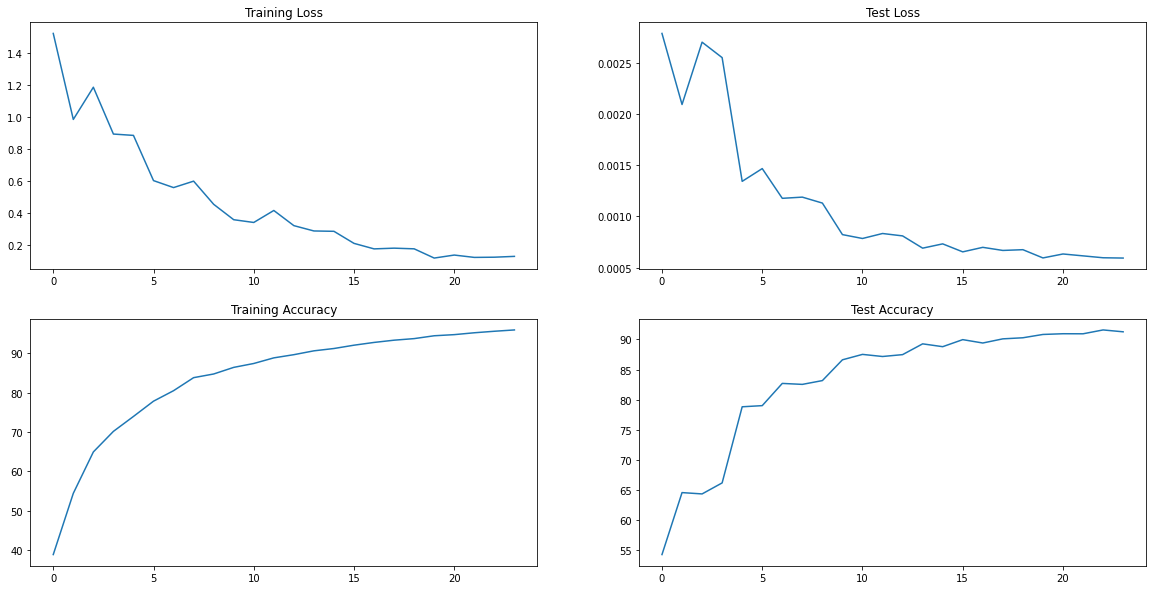

In [235]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)    

In [81]:
# from torch_lr_finder import LRFinder

# {'lr': 9.654713583179363e-05, 'momentum': 0.4250250057893233}
#{'lr': 1e-06, 'momentum': 0.36481247037960834, 'weight_decay': 1e-05}
# {'lr': 1e-06, 'momentum': 0.1236217963034376, 'weight_decay': 1e-05}
# # optimizer = optim.Adam(model.paraxwmeters(), lr=1e-7, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9, nesterov=True)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
# model = CustomResNet().to(device)
# # 0.02 with decay 1e-5 -> seems promising & 0.05 with 2e-5

# max_lr = 1e-3
# # 0.05, -> 
# # 1) 2.49e-1, -> can take more 2) 2.91e-1 3) 3.1e-1,-> 84% & 82% can take more 4) 4.3e-1 -> can take more perhaps, try
# # 5) 4.9e-1,  6) 5.9e-1 with opt lr 2.49e-2, 7) 5.1e-1 with 1.49e-2

# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr = max_lr/20, nesterov=True) #weight_decay=0.00125) # ["0.000125", "0.00025", "0.0005"]
# # 2.49e-2, -> 3.4e-2, 

# # optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-4)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
#                                                 max_lr=max_lr,
#                                                 pct_start=0.3,
#                                                 anneal_strategy='linear',
#                                                 verbose=False,
#                                                 epochs=24,
#                                                 cycle_momentum=False,
#                                                 steps_per_epoch=len(train_loader))



# train_losses = []
# train_accuracy = []
# test_losses = []
# test_accuracy = []
# lr_epochs = []

# start = time.perf_counter()

# train_eval_model(model=model,
#                  train_loader=train_loader,
#                  optimizer = optimizer,
#                  criterion=criterion,
#                  device=device,
#                  epochs=24,
#                  test=True,
#                  test_loader=test_loader,
#                  scheduler=scheduler,
#                  grad_clip=None,
#                 #  grad_clip_start_epoch=6,
#                 #  grad_clip_end_epoch=6,
#                  noise_level=0,
#                  ricap_apply=True,
#                  ricap_prob=0.04,
#                  ricap_beta=0.3)

# end = time.perf_counter()

# print(f"\n\nTime taken: {(end - start)//60} minutes and {int((end - start)%60)} seconds")

  0%|          | 0/98 [00:00<?, ?it/s]



RICAP has been set to True with probability: 0.04 and Beta value: 0.3



epoch num ===================================== 1
LR at epoch 1 start: --> [4e-05]



100%|██████████| 98/98 [00:10<00:00,  9.06it/s]



Ricap applied: 7.14 percent of total batch iterations

			Train metrics: accuracy: 8665/50000 (17.3300%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0041, accuracy: 2497/10000 (24.97000%)




epoch num ===================================== 2
LR at epoch 2 start: --> [0.0001735225659948907]



100%|██████████| 98/98 [00:10<00:00,  9.22it/s]



Ricap applied: 2.04 percent of total batch iterations

			Train metrics: accuracy: 15719/50000 (31.4380%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0033, accuracy: 4073/10000 (40.73000%)




epoch num ===================================== 3
LR at epoch 3 start: --> [0.0003070451319897814]



100%|██████████| 98/98 [00:09<00:00,  9.93it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 20901/50000 (41.8020%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0028, accuracy: 4904/10000 (49.04000%)




epoch num ===================================== 4
LR at epoch 4 start: --> [0.0004405676979846721]



100%|██████████| 98/98 [00:09<00:00,  9.89it/s]



Ricap applied: 5.10 percent of total batch iterations

			Train metrics: accuracy: 22286/50000 (44.5720%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0027, accuracy: 5302/10000 (53.02000%)




epoch num ===================================== 5
LR at epoch 5 start: --> [0.0005740902639795628]



100%|██████████| 98/98 [00:09<00:00,  9.98it/s]



Ricap applied: 3.06 percent of total batch iterations

			Train metrics: accuracy: 24298/50000 (48.5960%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0024, accuracy: 5657/10000 (56.57000%)




epoch num ===================================== 6
LR at epoch 6 start: --> [0.0007076128299744536]



100%|██████████| 98/98 [00:09<00:00,  9.98it/s]



Ricap applied: 3.06 percent of total batch iterations

			Train metrics: accuracy: 26071/50000 (52.1420%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0023, accuracy: 5966/10000 (59.66000%)




epoch num ===================================== 7
LR at epoch 7 start: --> [0.0008411353959693442]



100%|██████████| 98/98 [00:10<00:00,  9.19it/s]



Ricap applied: 10.20 percent of total batch iterations

			Train metrics: accuracy: 24954/50000 (49.9080%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0023, accuracy: 6014/10000 (60.14000%)




epoch num ===================================== 8
LR at epoch 8 start: --> [0.000974657961964235]



100%|██████████| 98/98 [00:10<00:00,  9.16it/s]



Ricap applied: 2.04 percent of total batch iterations

			Train metrics: accuracy: 29141/50000 (58.2820%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 6287/10000 (62.87000%)




epoch num ===================================== 9
LR at epoch 9 start: --> [0.0009517737594752187]



100%|██████████| 98/98 [00:09<00:00,  9.96it/s]



Ricap applied: 2.04 percent of total batch iterations

			Train metrics: accuracy: 30717/50000 (61.4340%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 6280/10000 (62.80000%)




epoch num ===================================== 10
LR at epoch 10 start: --> [0.0008922501880466473]



100%|██████████| 98/98 [00:10<00:00,  9.33it/s]



Ricap applied: 5.10 percent of total batch iterations

			Train metrics: accuracy: 30684/50000 (61.3680%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0018, accuracy: 6897/10000 (68.97000%)




epoch num ===================================== 11
LR at epoch 11 start: --> [0.0008327266166180758]



100%|██████████| 98/98 [00:10<00:00,  9.21it/s]



Ricap applied: 4.08 percent of total batch iterations

			Train metrics: accuracy: 32444/50000 (64.8880%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0017, accuracy: 7042/10000 (70.42000%)




epoch num ===================================== 12
LR at epoch 12 start: --> [0.0007732030451895045]



100%|██████████| 98/98 [00:09<00:00, 10.00it/s]



Ricap applied: 4.08 percent of total batch iterations

			Train metrics: accuracy: 33149/50000 (66.2980%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0016, accuracy: 7229/10000 (72.29000%)




epoch num ===================================== 13
LR at epoch 13 start: --> [0.0007136794737609331]



100%|██████████| 98/98 [00:09<00:00,  9.96it/s]



Ricap applied: 5.10 percent of total batch iterations

			Train metrics: accuracy: 33633/50000 (67.2660%)


[]

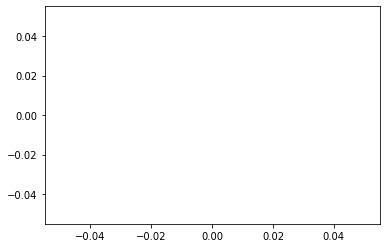

In [205]:
plt.plot(*zip(*lr_epochs))